# **Laboratorio 5: Codigos de las señales EEG con Ultracortex Mark IV**

## 1. Importar Librerias

In [13]:
pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.0 MB/s eta 0:00:00


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

## 3. Extracción de datos

Extraemos la data principal de nuestro dataframe, por ejemplo frecuencia de muestreo, numero de columnas (canales), numero de filas (muestras en el tiempo), nombre de las columnas y data en general.

In [19]:
import pandas as pd
import numpy as np
import mne

# === 1. CARGAR ARCHIVO ===
path = r"/content/OpenBCI-RAW-2025-09-17_12-45-51.txt"
df = pd.read_csv(path, sep=",", comment="%", engine="python")

# === 2. LIMPIAR COLUMNAS ===
df.columns = df.columns.str.strip()  # elimina espacios
print(f"{df.shape[0]} filas x {df.shape[1]} columnas")
print(df.columns.tolist())

# === 3. CALCULAR FRECUENCIA DE MUESTREO ===
t = df["Timestamp"].values
dt = np.diff(t).mean()
fs_estimada = 1.0 / dt
print(f"Frecuencia de muestreo estimada: {fs_estimada:.2f} Hz")

# Usamos la frecuencia nominal de OpenBCI (Cyton)
fs = 250.0

# === 4. SELECCIONAR CANALES EEG ===
eeg_cols = [col for col in df.columns if col.startswith("EXG Channel")]
print("Canales EEG:", eeg_cols)

# Extraer datos y transponer a (n_channels, n_times)
data = df[eeg_cols].values.T
print("Forma del array de datos:", data.shape)  # (8, n_muestras)

# === 5. CREAR INFO PARA MNE ===
ch_names = eeg_cols
ch_types = ["eeg"] * len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)

# === 6. CREAR OBJETO RAW ===
raw = mne.io.RawArray(data, info)
print(raw)

# === 7. RENOMBRAR CANALES A NOMENCLATURA ESTÁNDAR ===
# Correspondencia típica de OpenBCI Cyton 8ch → Sistema 10-20
rename_map = {
    "EXG Channel 0": "Fp1",
    "EXG Channel 1": "Fp2",
    "EXG Channel 2": "C3",
    "EXG Channel 3": "C4",
    "EXG Channel 4": "P7",
    "EXG Channel 5": "P8",
    "EXG Channel 6": "O1",
    "EXG Channel 7": "O2",
}

raw.rename_channels(rename_map)
print("Canales renombrados:", raw.ch_names)

# === 8. APLICAR MONTAGE ESTÁNDAR ===
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)
print("Montaje asignado correctamente.")


180227 filas x 25 columnas
['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6', 'EXG Channel 7', 'Accel Channel 0', 'Accel Channel 1', 'Accel Channel 2', 'Not Used', 'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)', 'Digital Channel 2 (D13)', 'Digital Channel 3 (D17)', 'Not Used.1', 'Digital Channel 4 (D18)', 'Analog Channel 0', 'Analog Channel 1', 'Analog Channel 2', 'Timestamp', 'Marker Channel', 'Timestamp (Formatted)']
Frecuencia de muestreo estimada: 246.73 Hz
Canales EEG: ['EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6', 'EXG Channel 7']
Forma del array de datos: (8, 180227)
Creating RawArray with float64 data, n_channels=8, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.
<RawArray | 8 x 180227 (720.9 s), ~11.0 MiB, data loaded>
Canales renombrados: ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', '

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


<Evoked | '' (average, N=1), 0 – 0 s, baseline off, 8 ch, ~15 KiB>

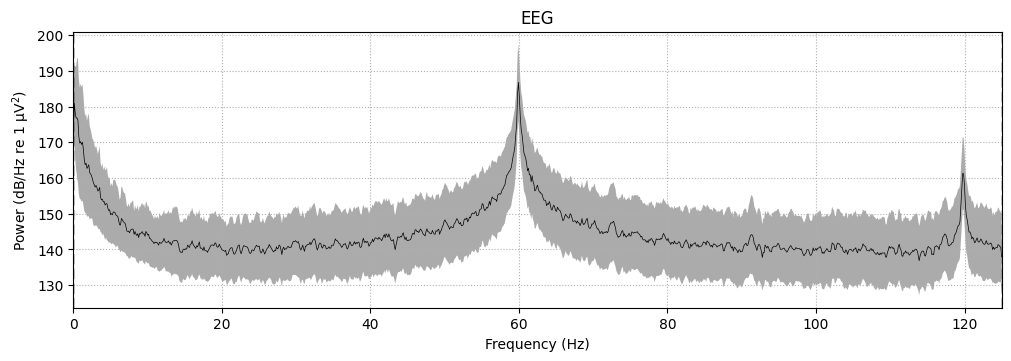

In [25]:
# === 9. VISUALIZAR SEÑALES ===
raw.info

# === 10. VISUALIZAR PSD ===
raw.plot_psd(average=True)

# === 11. CREAR EVOKED PARA TOPOGRAFÍA ===
# Usamos un promedio estático solo para visualizar
data_mean = np.mean(data, axis=1, keepdims=True)
evoked = mne.EvokedArray(data_mean, raw.info, tmin=0)
evoked.set_montage(montage)